<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Autocorrelation Tempogram</h1> 
</div>

<br/>


<p>
Following Section 6.2.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we show in this notebook how to compute a tempogram using a short-time autocorrelation method. A MATLAB implementation of this approach can be found in the  <a href="https://www.audiolabs-erlangen.de/resources/MIR/tempogramtoolbox">Tempogram Toolbox</a>.
    
<ul>
<li><span style="color:black">
Peter Grosche and Meinard Müller: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2011_GroscheMueller_TempogramToolbox_ISMIR-LateBreaking.pdf"><strong>Tempogram Toolbox: MATLAB implementations for tempo and pulse analysis of music recordings.</strong></a> Late-Breaking and Demo Session of the International Conference on Music Information Retrieval (ISMIR), Miami, USA, 2011. 
<br>
 <a href="https://www.audiolabs-erlangen.de/resources/MIR/tempogramtoolbox">Website of the Tempogram Toolbox.</a>    
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_GroscheM11_TempogramToolbox_ISMIR-lateBreaking.txt"> Bibtex </a>
</span></li>
</ul>        
</p> 

##  Autocorrelation

As a second periodicity estimation method, besides the <a href="C6S2_TempogramFourier.html">Fourier-based approach</a>, we now discuss an autocorrelation-based approach. Generally speaking, the **autocorrelation** is a mathematical tool for measuring the similarity of a signal with a time-shifted version of itself. Let $x:\mathbb{Z}\to\mathbb{R}$ be such discrete-time signal having finite energy. The autocorrelation $R_{xx}:\mathbb{Z}\to\mathbb{R}$ of the real-valued signal $x$ is defined by 

\begin{equation}
R_{xx}(\ell) = \sum_{m\in\mathbb{Z}} x(m)x(m-\ell),
\end{equation}

which yields a function that depends on the time-shift or **lag** parameter $\ell\in\mathbb{Z}$. The autocorrelation $R_{xx}(\ell)$ is maximal for $\ell=0$ and symmetric in $\ell$. Intuitively, if the autocorrelation is large for a given lag, then the signal contains repeating patterns that are separated by a time period as specified by the lag parameter.

In the following example, we consider a signal that consists of two click track patterns: one with period $9$ and one with period $14$. The autocorrelation has trivially a peak at lag $\ell=0$ (the signal is similar to itself), then at $\ell=9$ (first period), $\ell=14$ (second period), $\ell=18$ (twice the first period), $\ell=27$ (three times the first and, at $\ell=28$, twice the second period), and so on. In particular, if the autocorrelation has a peak at lag $\ell$, then it has peaks also at integer multiples of $\ell$. 

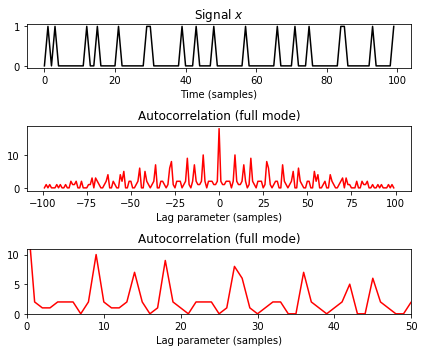

In [1]:
import os, sys
import librosa
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
%matplotlib inline

N = 100
x = np.zeros(N)
x[np.arange(1,N,14)] = 1
x[np.arange(3,N,9)] = 1

fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1.5, 1.5]}, figsize=(6, 5))       

ax[0].plot(x, 'k')
ax[0].set_title('Signal $x$')
ax[0].set_xlabel('Time (samples)')

r_xx = np.correlate(x, x, mode='full')
lag_axis = np.arange(-(N-1),N)
ax[1].plot(lag_axis,r_xx, 'r')
ax[1].set_title('Autocorrelation (full mode)')
ax[1].set_xlabel(r'Lag parameter (samples)')

r_xx = np.correlate(x, x, mode='full')
lag_axis = np.arange(-(N-1),N)
ax[2].plot(lag_axis,r_xx, 'r')
ax[2].set_title('Autocorrelation (full mode)')
ax[2].set_xlabel(r'Lag parameter (samples)')
ax[2].set_xlim([0,50])
ax[2].set_ylim([0,11])

plt.tight_layout()

##  Short-Time Autocorrelation

We now apply the autocorrelation in a local fashion for analyzing a given novelty function $\Delta:\mathbb{Z}\to\mathbb{R}$ in the neighborhood of a given time parameter $n$. To this end, we fix a window function $w:\mathbb{Z}\to\mathbb{R}$. The windowed version $\Delta_{w,n}:\mathbb{Z}\to\mathbb{R}$ localized at point $n\in\mathbb{Z}$ is defined by

\begin{equation}
  \Delta_{w,n}(m):=\Delta(m)w(m-n),
\end{equation}

$m\in\mathbb{Z}$. To obtain the **short-time autocorrelation** $\mathcal{A}:\mathbb{Z}\times\mathbb{Z}\to\mathbb{R}$, we compute the autocorrelation of $\Delta_{w,n}$:

\begin{equation}
\mathcal{A}(n,\ell) := \sum_{m\in\mathbb{Z}}\Delta(m)w(m-n)\Delta(m-\ell) w(m-n-\ell).
\end{equation}

In the following, we assume that the window function $w:[0:N-1]\to\mathbb{R}$ has finite length $N\in\mathbb{N}$. (As usual, for mathematical convenience, one may extend $w$ by zero outside the interval $[0:N-1]$.) Then the autocorrelation of the localized novelty function is zero for all but a finite number of time lag parameters. More precisely, one can show that $\mathcal{A}(n,\ell)=0$ for $|\ell|> N$. Because of this property and the symmetry of the autocorrelation, one only needs to consider the time lag parameters $\ell\in[0:N-1]$. Furthermore, because of the windowing, at most $N-\ell$ of the summands are nonzero. To balance out the effect of the windowing, the value $\mathcal{A}(n,\ell)$ may be divided by a factor that depends on the window properties and the overlap $N-\ell$ of the window and its time-shifted version. Visualizing the short-time autocorrelation $\mathcal{A}$ leads to a **time&ndash;lag representation** with a frame parameter $n\in\mathbb{Z}$ and a lag parameter $\ell\in[0:N-1]$.

## Implementation

In the following, we provide an implementation for computing the autocorrelation tempogram. The novelty curve $\Delta$ is assumed to have length $L\in\mathbb{N}$ with a sampling rate $F_\mathrm{s}^\Delta$. As window function $w$, we choose a rectangular window of length $N\in\mathbb{N}$. Furthermore, we introduce a hopsize parameter $H\in\mathbb{N}$. We use a [**centered view**](../C2/C2_STFT-Conventions.html), where the novelty function is zero-padded by half the window length. As a result, the first frame of $\mathcal{A}$ indexed by $n=0$ corresponds to the physical time position $t=0~\mathrm{sec}$. Furthermore, the hopsize parameter $H$ reduces the frame rate of the tempogram to $F_\mathrm{s}^\Delta/H$. Our algorithm loops over the frame indices $n$ and computes $\mathcal{A}(n,\ell)$ for all $\ell\in[0:N-1]$ using a single autocorrelation. As an illustrating example, we use a small excerpt of a recording of the Waltz No. 2 by Dimitri Shostakovich's Suite for Variety Orchestra No. 1. Furthermore, we use the parameters $F_\mathrm{s}^\Delta = 100~\mathrm{Hz}$ and $N=300$.

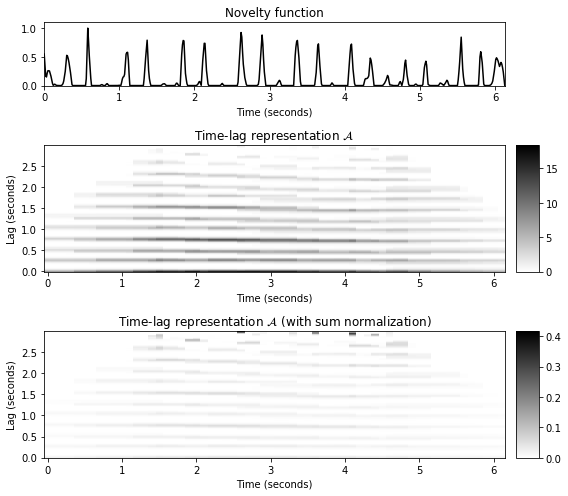

In [2]:
# @jit(nopython=True)  # not possible because of np.correlate with mode='full'
def compute_autocorrelation_local(x, Fs, N, H, norm_sum=True):
    """Compute local autocorrelation [FMP, Section 6.2.3]

    Notebook: C6/C6S2_TempogramAutocorrelation.ipynb

    Args:
        x: Input signal
        Fs: Sampling rate
        N: Window length
        H: Hop size
        norm_sum: Normalizes by the number of summands in local autocorrelation

    Returns:
        A: Time-lag representation
        T_coef: Time axis (seconds)
        F_coef_lag: Lag axis
    """
    #L = len(x)
    L_left = round(N / 2)
    L_right = L_left
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    L_pad = len(x_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    A = np.zeros((N, M))
    win = np.ones(N)
    if norm_sum is True:
        lag_summand_num = np.arange(N, 0, -1)
    for n in range(M):
        t_0 = n * H
        t_1 = t_0 + N
        x_local = win * x_pad[t_0:t_1]
        r_xx = np.correlate(x_local, x_local, mode='full')
        r_xx = r_xx[N-1:]
        if norm_sum is True:
            r_xx = r_xx / lag_summand_num
        A[:, n] = r_xx
    Fs_A = Fs / H
    T_coef = np.arange(A.shape[1]) / Fs_A
    F_coef_lag = np.arange(N) / Fs
    return A, T_coef, F_coef_lag

#fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F11_ClickTrack-BPM170-200.wav')
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=1)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

#Autocorrelation parameters
N = 300 #corresponding to 3 seconds (Fs_nov = 100 Hz)
H = 10

A, T_coef, F_coef_lag = compute_autocorrelation_local(nov, Fs_nov, N, H, norm_sum = False)
A_norm, T_coef, F_coef_lag = compute_autocorrelation_local(nov, Fs_nov, N, H)

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2, 2]}, figsize=(8,7))        

libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()

libfmp.b.plot_matrix(A, ax=[ax[1,0], ax[1,1]], T_coef=T_coef, F_coef=F_coef_lag,
                     title=r'Time-lag representation $\mathcal{A}$', ylabel='Lag (seconds)', colorbar=True);

libfmp.b.plot_matrix(A_norm, ax=[ax[2,0], ax[2,1]], T_coef=T_coef, F_coef=F_coef_lag,
                     title=r'Time-lag representation $\mathcal{A}$ (with sum normalization)', 
                     ylabel='Lag (seconds)', colorbar=True);
plt.tight_layout()

## Interpretation

We now have a closer look at the **time&ndash;lag representation** and its interpretation continuing our Shostakovich example. The window $w$ used in this example is a rectangular window that has a length corresponding to $3~\mathrm{sec}$ of the original audio recording. First, we consider the time index $n$ corresponding to the time instance $t=2~\mathrm{sec}$. To compute $\mathcal{A}(n,\ell)$, one only considers the section of the novelty function $\Delta$ between $0.5~\mathrm{sec}$ and $3.5~\mathrm{sec}$. The tempo of our Shostakovich recording is roughly $230~\mathrm{BPM}$ in this section. In other words, the duration of the interval between two subsequent beats is roughly $s=0.26~\mathrm{sec}$. Next, let us consider the lag parameter $\ell$ that corresponds to a time shift of $s=0.26~\mathrm{sec}$. Then, the novelty function in this section nicely correlates with its time-shifted version: the peaks of the section fall onto peaks of the section shifted by one beat period. The same holds when shifting the section by two, three or more beat periods. For example, this is the case for $s=0.78~\mathrm{sec}$ (three beat periods). This period corresponds to a tempo of $77~\mathrm{BPM}$, which is the tempo on the measure level. In contrast, when using a lag $\ell$ that corresponds to half a beat period $s=0.13~\mathrm{sec}$ (double tempo $461~\mathrm{BPM}$), the peaks of the section and the peaks of the shifted section miss each other, thus resulting in a coefficient $\mathcal{A}(n,\ell)$ close to zero.

<!--<img src="../data/C6/FMP_C6_F14.png" width="400px" align="middle" alt="FMP_C6_F14.png">-->

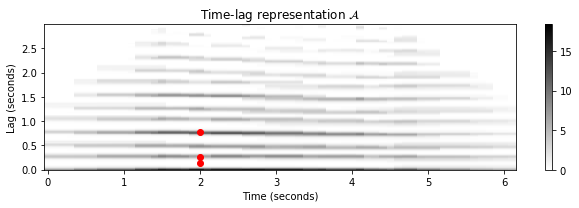

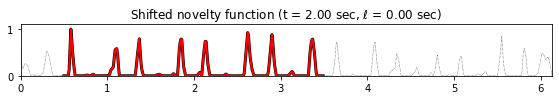

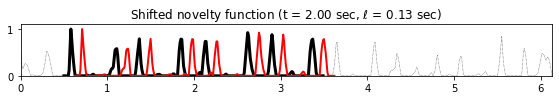

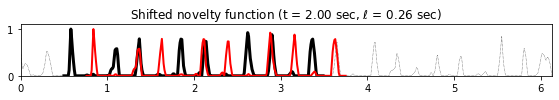

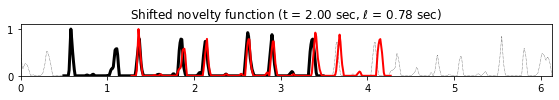

In [3]:
def plot_signal_local_lag(x, t_x, local_lag, t_local_lag, lag, xlim=None, figsize=(8, 1.5), title=''):
    """Visualize signal and local lag [FMP, Figure 6.14]

    Notebook: C6/C6S2_TempogramAutocorrelation.ipynb

    Args:
        x: Signal
        t_x: Time axis of x (given in seconds)
        local_lag: Local lag
        t_local_lag: Time axis of kernel (given in seconds)
        lag: Lag (given in seconds)
        figsize, title: Standard parameters for plotting

    Returns:
        fig:  Matplotlib figure handle
    """
    if xlim is None:
        xlim = [t_x[0], t_x[-1]]
    fig = plt.figure(figsize=figsize)
    plt.plot(t_x, x, 'k:', linewidth=0.5)
    plt.plot(t_local_lag, local_lag, 'k', linewidth=3.0)
    plt.plot(t_local_lag+lag, local_lag, 'r', linewidth=2)
    plt.title(title)
    plt.ylim([0, 1.1 * np.max(x)])
    plt.xlim(xlim)
    plt.tight_layout()
    return fig
    
time_sec = np.array([2, 2, 2])
lag_sec = np.array([0.13, 0.26, 0.78])
coef_n = (time_sec * Fs_nov/H).astype(int)
coef_k = (lag_sec * Fs_nov).astype(int)

fig, ax, im = libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, figsize=(9,3),
                     title=r'Time-lag representation $\mathcal{A}$', ylabel='Lag (seconds)', colorbar=True);
ax[0].plot(T_coef[coef_n], F_coef_lag[coef_k],'ro')

L = len(nov)
L_left = round(N/2)
L_right = L_left
nov_pad = np.concatenate( ( np.zeros(L_left), nov, np.zeros(L_right) ) )
L_pad = len(nov_pad)
win = np.ones(N)

time_sec = np.array([2, 2, 2, 2])
lag_sec = np.array([0, 0.13, 0.26, 0.78])
t_nov = np.arange(nov.shape[0])/Fs_nov

for i in range(len(time_sec)):
    t_0 = time_sec[i] * Fs_nov
    t_1 = t_0 + N
    nov_local = win*nov_pad[t_0:t_1]
    t_nov_local = (np.arange(t_0,t_1) - L_left)/Fs_nov
    lag = lag_sec[i]
    title=r'Shifted novelty function (t = %0.2f sec, $\ell$ = %0.2f sec)'%(time_sec[i], lag)
    fig = plot_signal_local_lag(nov, t_nov, nov_local, t_nov_local, lag, title=title)

## Autocorrelation Tempogram

To obtain a time&ndash;tempo representation from the time&ndash;lag representation, one needs to convert the lag parameter into a tempo parameter. To this end, one requires the frame rate or time resolution of the novelty function. Suppose that each time frame corresponds to $r$ seconds, then a time lag of $\ell$ (given in frames) corresponds to $\ell\cdot r$ seconds. Since a shift of $\ell\cdot r$ seconds corresponds to a rate of $1/(\ell\cdot r)~\mathrm{Hz}$, one obtains the tempo

\begin{equation}
   \tau = \frac{60}{r\cdot \ell}~\mathrm{BPM}.
\end{equation}

As an example, let us assume that the feature rate of the novelty function $\Delta$ is $F_\mathrm{s}^\Delta = 100~\mathrm{Hz}$ and $r=0.01~\mathrm{sec}$. In this case, the lag parameter $\ell=10$ corresponds to $600~\mathrm{BPM}$ and $\ell=200$ corresponds to $30~\mathrm{BPM}$. To obtain tempo values in a meaningful range, one uses in practice a maximum lag parameter $\ell_\mathrm{max}$ to specify the minimum tempo and a minimum lag parameter $\ell_\mathrm{min}$ to specify the maximum tempo. Note that when using a window length $N$, one needs to 

$$
      1\leq  \ell_\mathrm{min} \leq \ell_\mathrm{max} \leq N-1
$$

Based on the conversion from lag to BPM, the lag axis can be interpreted as a tempo axis. This allows us to define the **autocorrelation tempogram** $\mathcal{T}^\mathrm{A}$ by setting

\begin{equation}
\mathcal{T}^\mathrm{A}(n,\tau) := \mathcal{A}(n,\ell)
\end{equation}

for each tempo $\tau=60/(r\cdot\ell)$ with $\ell\in[ \ell_\mathrm{min}: \ell_\mathrm{max}]$. Note that in this case, since the tempo values are  reciprocal to the linearly sampled lag values, the tempo axis is sampled in a nonlinear fashion. To obtain a tempogram 

$$
\mathcal{T}^\mathrm{A}: \mathbb{Z} \times \Theta \to \mathbb{R}_{\geq 0}
$$ 

that is defined on the same tempo set $\Theta$ as the <a href="C6S2_TempogramFourier.html">Fourier tempogram</a> $\mathcal{T}^\mathrm{F}$, one can use standard resampling and interpolation techniques applied to the tempo domain. The conversion from lag to tempo as well as the interpolation to obtain a linear tempo axis are illustrated by the following code cell continuing our Shostakovich example.

<!--<img src="../data/C6/FMP_C6_F15_text.png" width="600px" align="middle" alt="FMP_C6_F15_text.png">-->

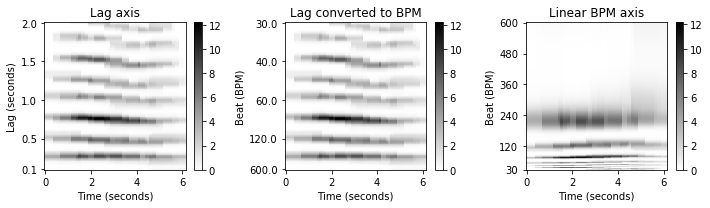

In [4]:
# @jit(nopython=True)
def compute_tempogram_autocorr(x, Fs, N, H, norm_sum=True, Theta=np.arange(30, 601)):
    """Compute autocorrelation-based tempogram

    Notebook: C6/C6S2_TempogramFourier.ipynb

    Args:
        x: Input signal
        Fs: Sampling rate
        N: Window length
        H: Hop size
        norm_sum:
        Theta: Set of tempi (given in BPM)

    Returns:
        tempogram: Tempogram
        T_coef: Time axis (seconds)
        F_coef_BPM: Tempo axis (BPM)
        A_cut: Time-lag representation (cut according to Theta)
        F_coef_lag_cut: Lag axis
    """
    tempo_min = Theta[0]
    tempo_max = Theta[-1]
    lag_min = int(np.ceil(Fs * 60 / tempo_max))
    lag_max = int(np.ceil(Fs * 60 / tempo_min))
    A, T_coef, F_coef_lag = compute_autocorrelation_local(x, Fs, N, H, norm_sum=False)
    A_cut = A[lag_min:lag_max+1, :]
    F_coef_lag_cut = F_coef_lag[lag_min:lag_max+1]
    F_coef_BPM_cut = 60 / F_coef_lag_cut
    F_coef_BPM = Theta
    tempogram = interp1d(F_coef_BPM_cut, A_cut, kind='linear',
                         axis=0, fill_value='extrapolate')(F_coef_BPM)
    return tempogram, T_coef, F_coef_BPM, A_cut, F_coef_lag_cut

Theta=np.arange(30, 601)
tempogram, T_coef, F_coef, A, F_coef_lag = compute_tempogram_autocorr(nov, 
                            Fs_nov, N, H, norm_sum = True, Theta=Theta)

fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]}, figsize=(10,3)) 

libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, ax=[ax[0]],
                     title='Lag axis', ylabel='Lag (seconds)', colorbar=True);
lag_yticks = np.array([F_coef_lag[0], 0.5, 1.0, 1.5, F_coef_lag[-1]])
ax[0].set_yticks(lag_yticks)

libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, ax=[ax[1]],
                     title='Lag converted to BPM', ylabel='Beat (BPM)', colorbar=True);
ax[1].set_yticks(lag_yticks)
ax[1].set_yticklabels(60/lag_yticks)

libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef, ax=[ax[2]],
                     title='Linear BPM axis', ylabel='Beat (BPM)', colorbar=True);
ax[2].set_yticks([F_coef[0], 120, 240, 360, 480, F_coef[-1]]);
plt.tight_layout()

## Tempo Harmonics and Subharmonics

In the [FMP notebook on tempo and beat](../C6/C6S2_TempoBeat.html), introduces the notion of tempo octave, harmonic, and subharmonic. In the following, we illustrate these concepts by considering a click track of increasing tempo (raising from $170$ to $200~\mathrm{BPM}$ over the course of $20~\mathrm{sec}$). This example illustrates that an **autocorrelation tempogram** exhibits **tempo subharmonics**, while suppressing tempo harmonics. The reason for this behavior is that a high correlation of a local section of the novelty function with the section shifted by $\ell$ samples also implies a high correlation with a section shifted by $k\cdot\ell$ lags for integers $k\in\mathbb{N}$. Assuming that $\ell$ corresponds to tempo $\tau$, the lag $k\cdot\ell$ corresponds to the subharmonic $\tau/k$. Note that this behavior stands in contrast to the [**Fourier tempogram**](../C6/C6S2_TempogramFourier.html), which emphasizes **tempo harmonics**, but suppresses tempo subharmonics.

<audio style="width: 320px;" src="../data/C6/FMP_C6_F11_ClickTrack-BPM170-200.mp3" type="audio/mpeg" controls="controls"></audio>

<!--<img src="../data/C6/FMP_C6_F11c.png" width="400px" align="middle" alt="FMP_C6_F11c.png">-->

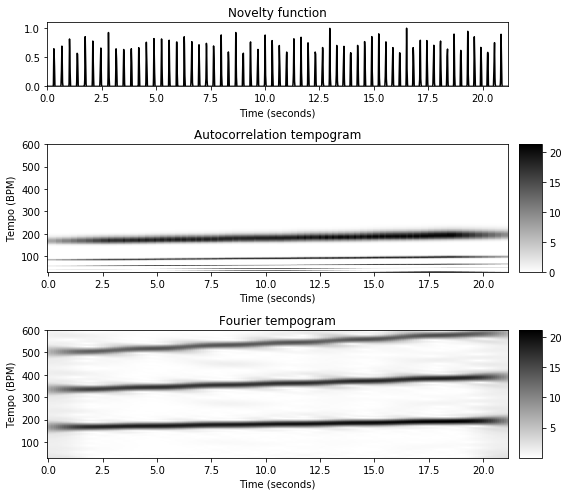

In [5]:
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F11_ClickTrack-BPM170-200.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=1)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

#Autocorrelation parameters
N = 500 #corresponding to 5 seconds (Fs_nov = 100 Hz)
H = 10
Theta=np.arange(30, 601)
tempogram_A, T_coef, F_coef, A, F_coef_lag = compute_tempogram_autocorr(nov, Fs_nov, N, H, 
                                                 norm_sum = True, Theta=Theta)

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2, 2]}, figsize=(8,7))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram_A, T_coef=T_coef, F_coef=F_coef, ax=[ax[1,0], ax[1,1]], 
                     title='Autocorrelation tempogram', ylabel='Tempo (BPM)', colorbar=True);


X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram_F = np.abs(X)

libfmp.b.plot_matrix(tempogram_F, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[2,0], ax[2,1]], 
                     title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True)
plt.tight_layout()

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Angel Villar-Corrales.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>